In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *
# from utilities import mask_boundary_points
# from utilities import get_invariants
# from utilities import get_tensor_functions
# from torchToFoam import writesymmtensor

# standard datatype
dtype = torch.double

In [167]:
def time():
    return datetime.datetime.now().strftime("%y-%m-%d_%H-%M")

In [168]:
def trace(tensor):
    return (tensor[:,0,0] + tensor[:,1,1] + tensor[:,2,2])

In [169]:
# set path to models and initialise arrays
# model_path = '../storage/models/periodic_hills/no_t_norm/ling/model.pt'
model_path = '../storage/models/periodic_hills/normalized/geneva/model.pt'

model = th.load(model_path)
_ = model.eval()  # mandatory, see torch.load doc

In [170]:
# read in tensor data
# pred_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/periodic_hills/2d-mesh/700_kEpsilon'
pred_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/periodic_hills/2d-mesh/700_kEpsilon'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep/rans/13700'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/conv_div_channel/rans/12600'
rans_time = max([entry for entry in os.listdir(pred_path) if entry.isnumeric()])

rs = th.load(os.sep.join([pred_path, rans_time, 'RS-torch.th']))
s = th.load(os.sep.join([pred_path, rans_time, 'S-torch.th']))
r = th.load(os.sep.join([pred_path, rans_time, 'R-torch.th']))
epsilon0 = th.load(os.sep.join([pred_path, rans_time, 'epsilon-torch.th']))
k0 = th.load(os.sep.join([pred_path, rans_time, 'k-torch.th']))
# cellCenters = th.tensor(th.load(os.sep.join([pred_path, rans_time, 'cellCenters-torch.th'])))
cellCenters = th.load(os.sep.join([pred_path, rans_time, 'grid-torch.th'])).clone().detach()

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# get b_rans
b_rans = barymap.anisotropy(rs, k0)

# normalize S and R
s_hat = k/epsilon*s
r_hat = k/epsilon*r

inv = get_invariants(s_hat, r_hat)
inv_mean_std = mean_std_scaling(inv)
inv_sigmoid = sigmoid_scaling(inv)
t = get_tensor_functions(s_hat, r_hat).reshape(-1,10,9)
# index = th.isnan(t[:,4,0])
# t[index,4,:] = 0.0 #  = 0.0

# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills/tensordata/700'
# path_dns = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep/dns/13700/'
# rs_dns = th.load(os.sep.join([path_dns, 'RS-torch.th']))
# k0_dns = th.load(os.sep.join([path_dns, 'k-torch.th']))
# b_dns = barymap.anisotropy(rs_dns, k0_dns)
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
cellCenters_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

In [171]:
t_matrix = t.reshape(-1,10,3,3)
t_trace = t_matrix[:,:,0,0] + t_matrix[:,:,1,1] + t_matrix[:,:,2,2]
max_val = th.max(t_trace)
print(max_val)
max_index = th.argmax(t_trace)
# cellCenters[max_index]
t_zero_trace = enforce_zero_trace(t_matrix)
t_trace = t_zero_trace[:,:,0,0] + t_zero_trace[:,:,1,1] + t_zero_trace[:,:,2,2]
print(th.max(t_trace))

tensor(1.1350, dtype=torch.float64)
tensor(2.6849e-08, dtype=torch.float64)


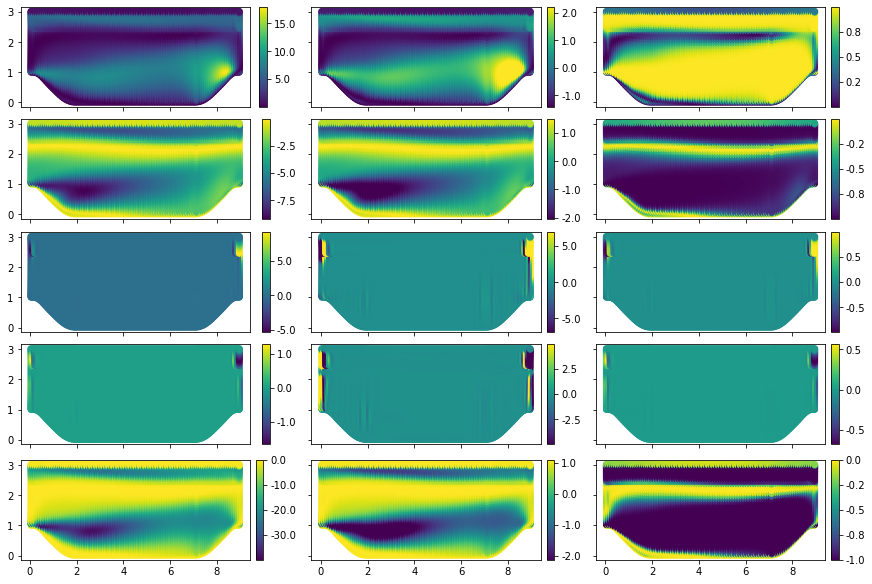

In [173]:
# set path to save figures
fig_path = '/home/leonriccius/gkm/Masters_Thesis/Images/NN'

# create figure
fig, ax = plt.subplots(5, 3, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

# loop over invariants
for i in range(5):
    plot_unscaled = ax[i,0].scatter(cellCenters[:,0], cellCenters[:,1], c=inv[:,i])
    cbar_unscaled = fig.colorbar(plot_unscaled, ax=ax[i,0], format='%.1f', pad=0.0)
    
    plot_mean_std = ax[i,1].scatter(cellCenters[:,0], cellCenters[:,1], c=inv_mean_std[:,i])
    cbar_mean_std = fig.colorbar(plot_mean_std, ax=ax[i,1], format='%.1f', pad=0.0)
    
    plot_sigmoid = ax[i,2].scatter(cellCenters[:,0], cellCenters[:,1], c=inv_sigmoid[:,i])
    cbar_sigmoid = fig.colorbar(plot_sigmoid, ax=ax[i,2], format='%.1f', pad=0.0)
    
# save figure
fig_name = time() + '_phill_scaling_options'
# plt.savefig(os.sep.join([fig_path, fig_name + '.pdf']), format='pdf')
# tikz.save(os.sep.join([fig_path, fig_name + '.pgf']))
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

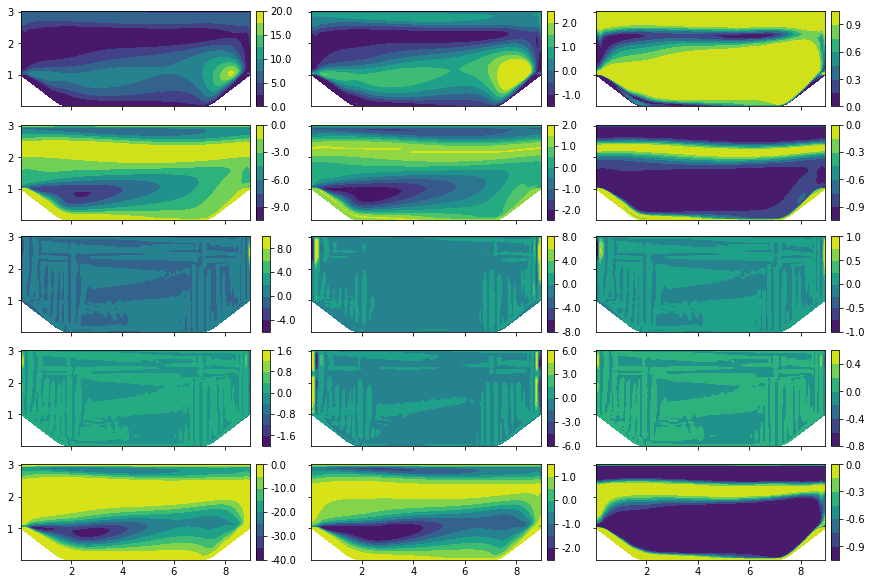

In [174]:
fig_path = '/home/leonriccius/Desktop'

# create figure
fig, ax = plt.subplots(5, 3, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)

for i in range(5):
    unscaled = ax[i,0].tricontourf(cellCenters[:,0], cellCenters[:,1], inv[:,i])
    mean_std = ax[i,1].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_mean_std[:,i])
    sigmoid = ax[i,2].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_sigmoid[:,i])
    
    cbar_unscaled = fig.colorbar(unscaled, ax=ax[i,0], format='%.1f', pad=0.0)
    cbar_mean_std = fig.colorbar(mean_std, ax=ax[i,1], format='%.1f', pad=0.0)
    cbar_sigmoid = fig.colorbar(sigmoid, ax=ax[i,2], format='%.1f', pad=0.0)
    
    cbar_unscaled.ax.locator_params(nbins=5)
    cbar_mean_std.ax.locator_params(nbins=5)
    cbar_sigmoid.ax.locator_params(nbins=5)
    
# save figure
fig_name = time() + '_phill_scaling_options'
# plt.savefig(os.sep.join([fig_path, fig_name + '.pdf']), format='pdf')
# tikz.save(os.sep.join([fig_path, fig_name + '.pgf']))
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)

In [175]:
# take values from cells closest to inflow boundary as boundary field
x_min = th.min(cellCenters_dns[:,0])
print(x_min)
index = th.where(cellCenters_dns[:,0]==x_min)
cellCenters_dns[index]
b_dns_boundary = b_dns[index]

tensor(0.0402)


In [176]:
b_pred,_ = model(inv_mean_std,t) #t_zero_trace.reshape(-1,10,9))

In [177]:
b_pred = b_pred.reshape(-1,3,3)
b_pred.shape

torch.Size([6111, 3, 3])

In [178]:
b_list = [('Inlet', 'fixedValue_nonuniform', b_dns_boundary),
          ('Outlet', 'zeroGradient'),
          ('TopWall', 'fixedValue_uniform'),
          ('BottomWall', 'fixedValue_uniform'),
          ('SideWall1', 'empty'),
          ('SideWall2', 'empty')]

In [179]:
# writesymmtensor(b_dns, os.sep.join([pred_path, rans_time, 'b_ml']), b_list)
# writesymmtensor(b_dns, os.sep.join(['/home/leonriccius/Desktop', 'b_dd_jupyter']), b_list)

In [180]:
# index = th.where(cellCenters[:,0]>2.)
# print(index)
# th.min(cellCenters[index][:,0])

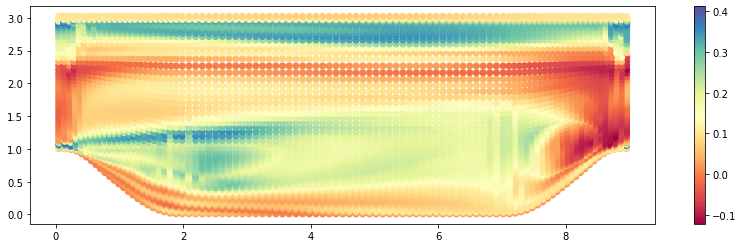

In [181]:
fig, ax = plt.subplots(figsize=(14,4))
# b_dd = ax.scatter(cellCenters[index][:,0], cellCenters[index][:,1], c=t[index][:,9,1].detach().numpy(), cmap="Spectral")
b_dd = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_pred[:,0,0].detach().numpy(), cmap="Spectral")
fig.colorbar(b_dd)
# ax.scatter(cellCenters[index,0], cellCenters[index,1])

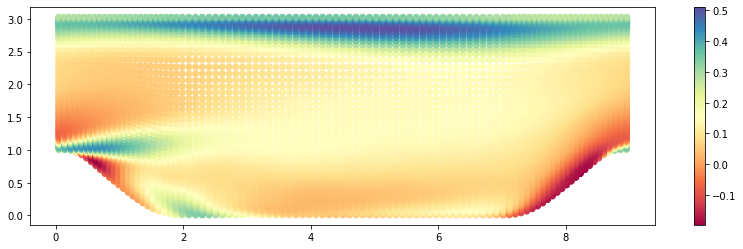

In [182]:
fig, ax = plt.subplots(figsize=(14,4))
b_dd = ax.scatter(cellCenters_dns[:,0], cellCenters_dns[:,1], c=b_dns[:,0,0].detach().numpy(), cmap="Spectral")
fig.colorbar(b_dd)
# ax.scatter(cellCenters[index,0], cellCenters[index,1])

In [183]:
b_dns_cut = b_dns[index]
cellCenters_dns_cut = cellCenters_dns[index]

In [184]:
index_nan = th.isnan(b_dns_cut[:,0,0])

In [185]:
print(th.max(index_nan))

tensor(False)


In [186]:
b_dns_cut_cut = b_dns_cut[index_nan==False]
cellCenters_dns_cut_cut = cellCenters_dns_cut[index_nan==False]

In [187]:
cellCenters_dns_cut_cut.shape

torch.Size([14, 2])

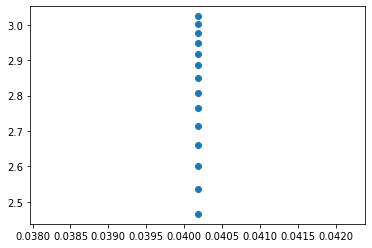

In [188]:
fig, ax = plt.subplots()
ax.scatter(cellCenters_dns_cut_cut[:,0], cellCenters_dns_cut_cut[:,1])

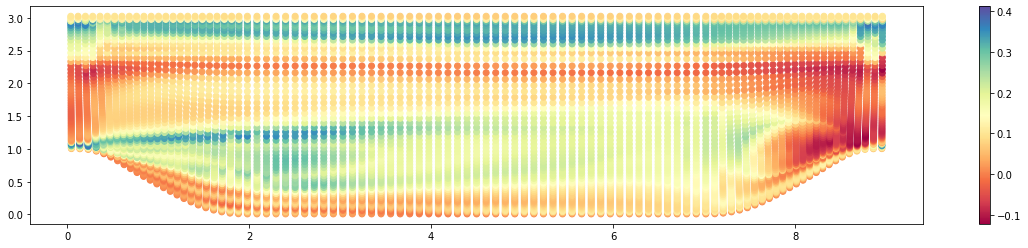

In [189]:
fig, ax = plt.subplots(figsize=(20,4))
b_dd = ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_pred[:,0,0].detach().numpy(), cmap="Spectral")
fig.colorbar(b_dd)
# ax.scatter(cellCenters[index,0], cellCenters[index,1])

# ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_interp)

/home/leonriccius/PycharmProjects/data_driven_rans/scripts/barymap.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eig_val_sorted[i] = eig_val[i, val]
/home/leonriccius/PycharmProjects/data_driven_rans/scripts/barymap.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  self.eig_vec_sorted[i] = eig_vec[i, :, val]


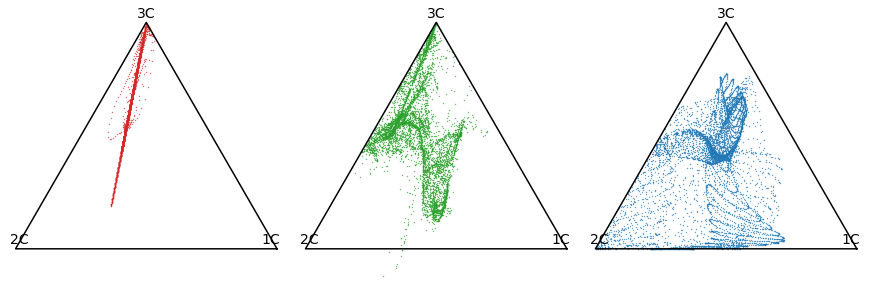

In [190]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True, constrained_layout=True)

ax[0].axis('equal')
ax[0].axis('off')
ax[1].axis('equal')
ax[1].axis('off')
ax[2].axis('equal')
ax[2].axis('off')

barm_rans = BarMap()
# barm_rans.load_from_variable(b_rans[index], cellCenters[index][:,0:2])
barm_rans.load_from_variable(b_rans, cellCenters[:,0:2])
barm_rans.calculate_barycentric_coordinates()
barm_rans.plot_triangle(ax[0])
barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3])

barm_pred = BarMap()
# barm_pred.load_from_variable(b_pred[index].detach().numpy(), cellCenters[index][:,0:2])
barm_pred.load_from_variable(b_pred.detach().numpy(), cellCenters[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[1])
barm_pred.plot_data_points(ax[1], color=sns.color_palette()[2])

barm_dns = BarMap()
# barm_dns.load_from_path(path_dns)
barm_dns.load_from_variable(b_dns, cellCenters_dns[:,0:2])
barm_dns.calculate_barycentric_coordinates()
barm_dns.plot_triangle(ax[2])
barm_dns.plot_data_points(ax[2], color=sns.color_palette()[0])

for axs in ax.flat:
        axs.text(0.98, 0.2, '1C', transform=axs.transAxes, fontsize=14,
            horizontalalignment='right', verticalalignment='top')
        axs.text(0.01, 0.2, '2C', transform=axs.transAxes, fontsize=14,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.96, '3C', transform=axs.transAxes, fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
        
# save figure
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/abstract'
fig_name = time() + 'barmap_conv.svg'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='svg')

In [ ]:
fig, ax = plt.subplots()
barm_pred.plot_triangle(ax)
barm_pred.plot_data_points(ax)
ax.axis('equal')
# plt.xlim([0,1])
# plt.ylim([0,1])

In [219]:
b_raw = th.rand(3,3) - 0.5
b1 = th.tensor([[[2.,1.,0.],[1.,2.,0.],[0.,0.,1.]], 0.5 * (b_raw + b_raw.transpose(0,1))])
b_trace = b1[:,0,0] + b1[:,1,1] + b1[:,2,2]
b1 = b1 - 1./3. * th.eye(3).unsqueeze(0) * b_trace.unsqueeze(1).unsqueeze(2)
print(b1, b1.shape)

tensor([[[ 0.3333,  1.0000,  0.0000],
         [ 1.0000,  0.3333,  0.0000],
         [ 0.0000,  0.0000, -0.6667]],

        [[-0.1900,  0.0170, -0.0781],
         [ 0.0170, -0.0704,  0.0776],
         [-0.0781,  0.0776,  0.2604]]]) torch.Size([2, 3, 3])


In [162]:
# b_test = b.clone()
# b_test_real = enforce_realizability(b_test)

In [220]:
# b1 = b_pred.clone()

In [234]:
eigval, eigvec = th.symeig(b1, eigenvectors=True)
print(eigval)
labels_1 = eigval[:,2] < (3*th.abs(eigval[:,1]) - eigval[:,1])*.5
labels_2 = eigval[:,2] > 1./3. - eigval[:,1]

tensor([[-0.6667, -0.6667,  1.3333],
        [-0.2100, -0.0788,  0.2888]])


In [235]:
print(labels_1, labels_2)

tensor([ True, False]) tensor([ True, False])


In [236]:
print(eigval)
eigval[0] *= (3. * th.abs(eigval[0][1]) - eigval[0][1]) / (2.*eigval[0][2])
print('\n',eigval)

tensor([[-0.6667, -0.6667,  1.3333],
        [-0.2100, -0.0788,  0.2888]])

 tensor([[-0.6667, -0.6667,  1.3333],
        [-0.2100, -0.0788,  0.2888]])


In [237]:
eigval[:,2] < (3*th.abs(eigval[:,1]) - eigval[:,1])/2.

tensor([ True, False])

In [76]:
eigval

tensor([[ 1.0000,  1.0000,  3.0000],
        [-0.6529, -0.2503, -0.1261]])

In [77]:
th.diag_embed(eigval)

tensor([[[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  3.0000]],

        [[-0.6529,  0.0000,  0.0000],
         [ 0.0000, -0.2503,  0.0000],
         [ 0.0000,  0.0000, -0.1261]]])

In [78]:
print(eigvec,'\n\n', eigvec.transpose(1,2))

tensor([[[-0.7071,  0.0000,  0.7071],
         [ 0.7071,  0.0000,  0.7071],
         [ 0.0000,  1.0000,  0.0000]],

        [[-0.4285,  0.8565,  0.2877],
         [-0.3786, -0.4593,  0.8036],
         [ 0.8204,  0.2354,  0.5211]]]) 

 tensor([[[-0.7071,  0.7071,  0.0000],
         [ 0.0000,  0.0000,  1.0000],
         [ 0.7071,  0.7071,  0.0000]],

        [[-0.4285, -0.3786,  0.8204],
         [ 0.8565, -0.4593,  0.2354],
         [ 0.2877,  0.8036,  0.5211]]])


In [79]:
eigvec.matmul(th.diag_embed(eigval).matmul(eigvec.transpose(1,2)))

tensor([[[ 2.0000,  1.0000,  0.0000],
         [ 1.0000,  2.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000]],

        [[-0.3139, -0.0366,  0.1602],
         [-0.0366, -0.2278,  0.1770],
         [ 0.1602,  0.1770, -0.4875]]])